In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [12]:
yf_data = yf.download('F', start="1800-01-01")
yf_data.reset_index(inplace=True)
yf_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,F,F,F,F,F,F
0,1972-06-01 00:00:00+00:00,0.226079,2.153220,2.173495,2.149165,0.000000,1091238
1,1972-06-02 00:00:00+00:00,0.225653,2.149165,2.173495,2.141055,2.153220,1174468
2,1972-06-05 00:00:00+00:00,0.225653,2.149165,2.169440,2.141055,2.149165,5209582
3,1972-06-06 00:00:00+00:00,0.223099,2.124835,2.157275,2.116725,2.149165,1424158
4,1972-06-07 00:00:00+00:00,0.221821,2.112670,2.137000,2.112670,2.124835,675088


In [13]:
# Daily returns calculations 
data = yf_data[["Date", "Adj Close"]]
data.set_index("Date", inplace=True)
data = data.rename(columns={"Adj Close": "Ford stock price"})
data["Daily returns"] = data["Ford stock price"].pct_change()*100
data = data.loc[data["Daily returns"] != 0]

# Volatility calculations 
rolling_window = 20
data["Rolling Mean"] = data["Daily returns"].rolling(window=rolling_window).mean()
data["Rolling Variance"] = data["Daily returns"].rolling(window=rolling_window).apply(
    lambda x: ((x - x.mean()) ** 2).sum() / (len(x) - 1), raw=True
)
data["Volatility"] = data["Rolling Variance"] ** 0.5
data.drop(columns=["Rolling Mean", "Rolling Variance"], inplace=True)

# Drop NA rows
data.dropna(axis=0, how="any", inplace=True)

data

Price,Ford stock price,Daily returns,Volatility
Ticker,F,,
Date,,,
1972-07-03 00:00:00+00:00,0.216712,-0.391365,0.665887
1972-07-05 00:00:00+00:00,0.215435,-0.589412,0.671242
1972-07-06 00:00:00+00:00,0.217990,1.185841,0.706351
1972-07-07 00:00:00+00:00,0.217138,-0.390716,0.701284
1972-07-10 00:00:00+00:00,0.214583,-1.176376,0.727103
...,...,...,...
2024-11-21 00:00:00+00:00,10.800000,0.652383,2.786684
2024-11-22 00:00:00+00:00,11.180000,3.518520,2.875956


Text(0, 0.5, 'Ford stock price')

<Figure size 1200x600 with 0 Axes>

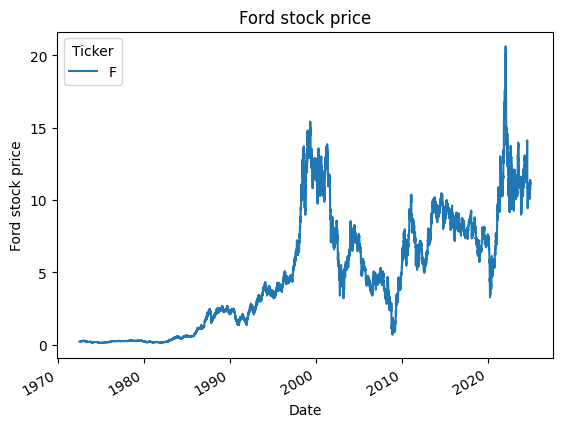

In [14]:
plt.figure(figsize=(12, 6))
data.plot(y='Ford stock price', title='Ford stock price')
plt.xlabel('Date')
plt.ylabel('Ford stock price')

In [15]:
print(f"Mean daily return is {round(data['Daily returns'].mean(), 5)}%")
print(f"Mean volatility over stock returns is {round(data['Volatility'].mean(), 5)}")

print(f"\nAnnualized mean daily return is {round(data['Daily returns'].mean()*252, 5)}%")
print(f"Annualized mean volatility over stock returns is {round(data['Volatility'].mean()*(252**0.5), 5)}")

Mean daily return is 0.05816%
Mean volatility over stock returns is 2.05092

Annualized mean daily return is 14.65518%
Annualized mean volatility over stock returns is 32.55734


TASK 2 -> GBM and Heston Models

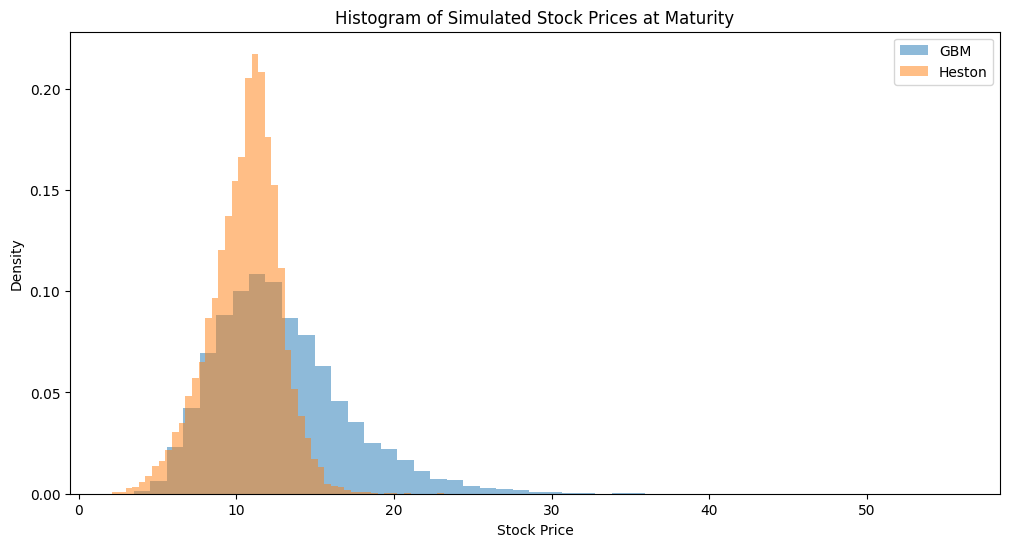

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters
S0 = data["Ford stock price"].iloc[-1] # Initial stock price
S0 = float(S0.iloc[0])
alpha = (data['Daily returns'].mean()*252)/100  # Mean annualized return (drift)
sigma = data['Volatility'].mean()*(252**0.5)/100  # Annualized volatility
dt = 1/252  # Time step (1 trading day)
T = 1  # Total time (1 year)
N = int(T / dt)  # Number of time steps (252 days)
simulations = 10000  # Number of simulated paths

# Geometric Brownian Motion Simulation
np.random.seed(42)  # Set seed for reproducibility
random_numbers = np.random.normal(0, 1, (simulations, N))  # Generate standard normal random numbers
dW = random_numbers * np.sqrt(dt)  # Scale random numbers by sqrt(dt) for Brownian motion
W = np.cumsum(dW, axis=1)  # Compute cumulative sum along time axis for Brownian motion
t = np.arange(1, N+1) * dt  # Time points for the simulation
drift = (alpha - 0.5 * sigma**2) * t  # Compute the deterministic drift component of GBM
stock_paths_gbm = S0 * np.exp(sigma * W + drift)  # Compute GBM stock price paths

# Extract stock prices at maturity
stock_prices_gbm = stock_paths_gbm[:, -1]  # Final stock prices for each path at maturity (T)

# Heston Model Parameters
xi = 0.3  # Volatility of variance
kappa = 2.0  # Rate of mean reversion
theta = 0.04  # Long-run variance
rho = -0.7  # Correlation between stock price and variance
v0 = sigma**2  # Initial variance, squared GBM volatility

# Heston Model Simulation
v = np.full((simulations, N), v0)  # Initialize variance paths with the initial variance
random_numbers_1 = np.random.normal(0, 1, (simulations, N))  # Independent normal random numbers for W_S
random_numbers_2 = np.random.normal(0, 1, (simulations, N))  # Independent normal random numbers for W_V
dW_S = random_numbers_1 * np.sqrt(dt)  # Scale random numbers for stock price Brownian motion
dW_V = rho * random_numbers_1 * np.sqrt(dt) + np.sqrt(1 - rho**2) * random_numbers_2 * np.sqrt(dt)  
# Create correlated Brownian motion for variance using rho

# Simulate variance and enforce non-negativity
for i in range(1, N):  # Iterate over time steps
    v[:, i] = v[:, i-1] + kappa * (theta - v[:, i-1]) * dt + xi * np.sqrt(np.maximum(v[:, i-1], 0)) * dW_V[:, i-1]  
    # Update variance based on Heston stochastic variance formula
    v[:, i] = np.maximum(v[:, i], 0)  # Ensure variance stays non-negative

# Simulate stock prices
W_S = np.cumsum(dW_S, axis=1)  # Compute cumulative Brownian motion for stock prices
integral_v = np.cumsum(v * dt, axis=1)  # Compute integral of variance over time
stock_paths_heston = S0 * np.exp(W_S * np.sqrt(v) - 0.5 * integral_v)  
# Compute Heston stock price paths using stochastic volatility

# Extract stock prices at maturity
stock_prices_heston = stock_paths_heston[:, -1]  # Final stock prices for each path at maturity (T)

# Histograms
bins = 50  # Number of bins for the histogram
plt.figure(figsize=(12, 6))  # Create a figure with specified size

plt.hist(stock_prices_gbm, bins=bins, alpha=0.5, label='GBM', density=True)  
# Plot histogram for GBM stock prices
plt.hist(stock_prices_heston, bins=bins, alpha=0.5, label='Heston', density=True)  
# Plot histogram for Heston stock prices
plt.title("Histogram of Simulated Stock Prices at Maturity")  # Add a title to the plot
plt.xlabel("Stock Price")  # Label the x-axis
plt.ylabel("Density")  # Label the y-axis
plt.legend()  # Add a legend to distinguish GBM and Heston
plt.show()  # Display the plot
